### Import Library 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Load the dataset
df = pd.read_csv("outbreaks.csv")
df.head()

,Year,Month,State,Location,Food,Ingredient,Species,Serotype/Genotype,Status,Illnesses,Hospitalizations,Fatalities
0,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,20,0.0,0.0
1,1998,January,California,NaN,Custard,NaN,NaN,NaN,NaN,112,0.0,0.0
2,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,35,0.0,0.0
3,1998,January,California,Restaurant,"Fish, Ahi",NaN,Scombroid toxin,NaN,Confirmed,4,0.0,0.0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",NaN,Salmonella enterica,Enteritidis,Confirmed,26,3.0,0.0


### Data Cleaning & Preprocessing

In [3]:
# Check missing values
missing_values = df.isnull().sum()

In [4]:
# Fill missing values
df_cleaned = df.copy()

In [5]:
# Fill missing categorical columns with "Unknown"
categorical_cols = ['Location', 'Food', 'Ingredient', 'Species', 'Serotype/Genotype', 'Status']
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna('Unknown')

In [6]:
# Fill numeric columns with 0
df_cleaned[['Hospitalizations', 'Fatalities']] = df_cleaned[['Hospitalizations', 'Fatalities']].fillna(0)

In [7]:
# Convert categorical columns to category dtype
for col in categorical_cols + ['State', 'Month']:
    df_cleaned[col] = df_cleaned[col].astype('category')

In [8]:
# Create a binary target variable: Was anyone hospitalized?
df_cleaned['Hospitalized'] = df_cleaned['Hospitalizations'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
# Preview cleaned data
df_cleaned.head()

,Year,Month,State,Location,Food,Ingredient,Species,Serotype/Genotype,Status,Illnesses,Hospitalizations,Fatalities,Hospitalized
0,1998,January,California,Restaurant,Unknown,Unknown,Unknown,Unknown,Unknown,20,0.0,0.0,0
1,1998,January,California,Unknown,Custard,Unknown,Unknown,Unknown,Unknown,112,0.0,0.0,0
2,1998,January,California,Restaurant,Unknown,Unknown,Unknown,Unknown,Unknown,35,0.0,0.0,0
3,1998,January,California,Restaurant,"Fish, Ahi",Unknown,Scombroid toxin,Unknown,Confirmed,4,0.0,0.0,0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",Unknown,Salmonella enterica,Enteritidis,Confirmed,26,3.0,0.0,1


### EDA

In [10]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [11]:
# 1. Trend of total illnesses and hospitalizations per year
illness_trend = df_cleaned.groupby('Year')[['Illnesses', 'Hospitalizations']].sum().reset_index()

In [83]:
# 2. Top 10 food items associated with hospitalization
top_foods = df_cleaned[df_cleaned['Hospitalized'] == 1]['Food'].value_counts().head(10)
top_foods

Food
Unknown                           1679
Ground Beef, Hamburger              30
Multiple Foods                      29
Pork, Bbq                           28
Oysters, Raw                        25
Chicken                             24
Ground Beef, Unspecified            23
Salad, Unspecified                  22
Milk, Whole Milk Unpasteurized      19
Pork, Roasted                       19
Name: count, dtype: int64

In [13]:
# 3. Top 10 locations where hospitalizations occurred
top_locations = df_cleaned[df_cleaned['Hospitalized'] == 1]['Location'].value_counts().head(10)

In [82]:
# 4. Top 10 affected states (by illness count)
top_states = df_cleaned.groupby('State')['Illnesses'].sum().sort_values(ascending=False).head(10)
top_states

C:\Users\asus\AppData\Local\Temp\ipykernel_10748\1329791490.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_states = df_cleaned.groupby('State')['Illnesses'].sum().sort_values(ascending=False).head(10)


State
California      39992
Illinois        24700
Multistate      24573
Florida         23050
Ohio            20451
New York        17407
Michigan        14471
Texas           14187
Minnesota       13533
Pennsylvania    11374
Name: Illnesses, dtype: int64

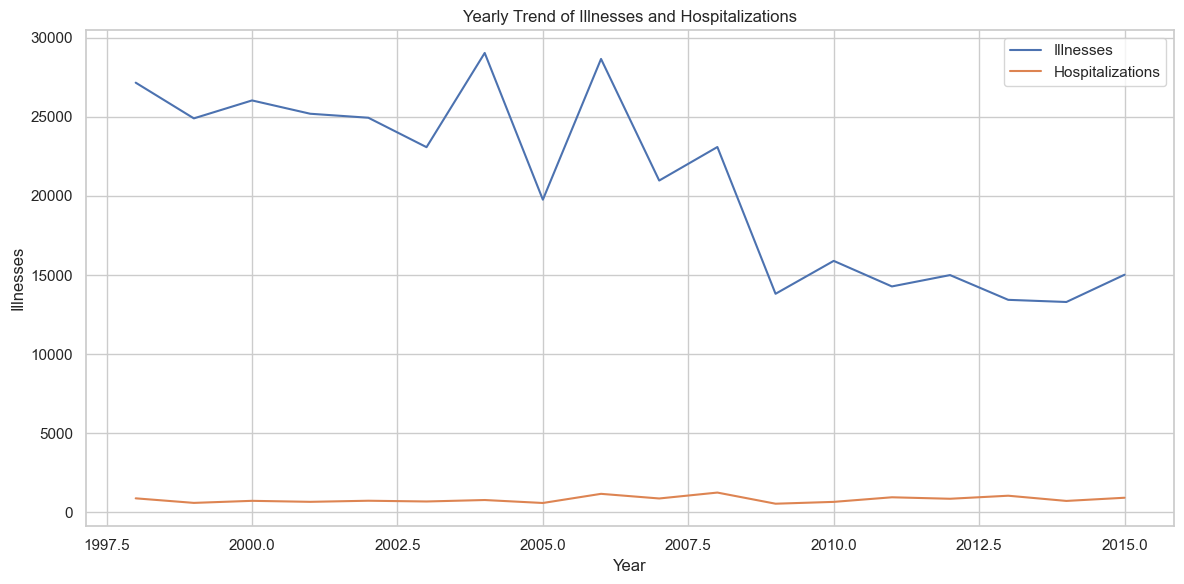

In [41]:
# Trend over years
plt.figure(figsize=(12, 6))

sns.lineplot(data=illness_trend, x='Year', y='Illnesses', label='Illnesses')
sns.lineplot(data=illness_trend, x='Year', y='Hospitalizations', label='Hospitalizations')
plt.title("Yearly Trend of Illnesses and Hospitalizations")
plt.legend()

plt.tight_layout()
plt.show()

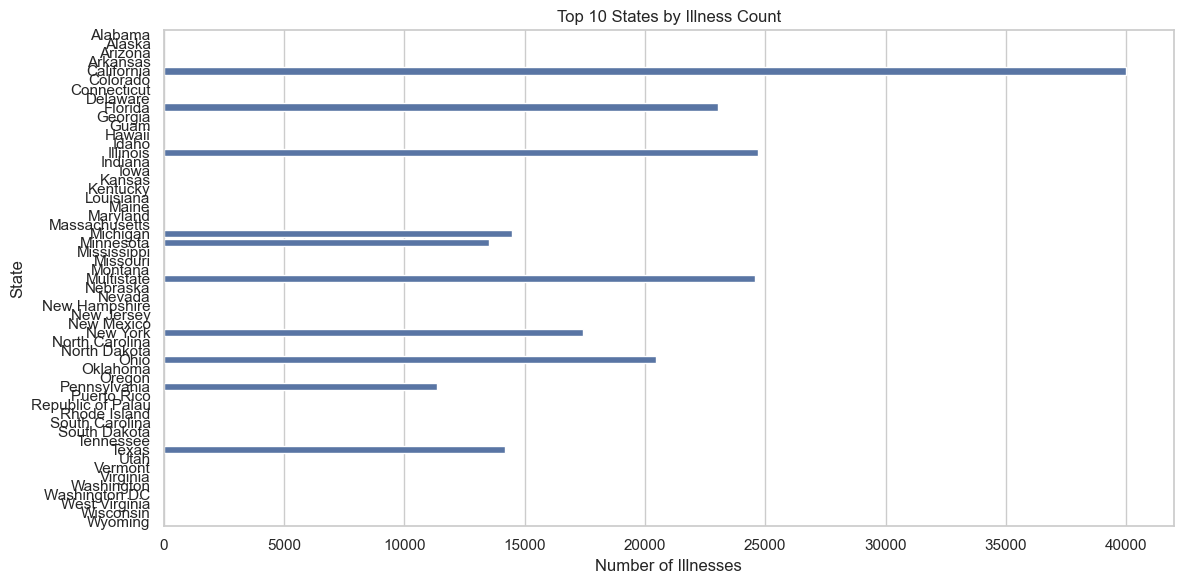

In [77]:
# Top affected states
plt.figure(figsize=(12,6))

sns.barplot(x=top_states.values, y=top_states.index)
plt.title("Top 10 States by Illness Count")
plt.xlabel("Number of Illnesses")

plt.tight_layout()
plt.show()

### Model Training

In [47]:
# Copy cleaned dataset
df_model = df_cleaned.copy()

In [48]:
# Select features and target
features = ['Year', 'Month', 'State', 'Location', 'Food']
target = 'Hospitalized'

In [49]:
# Encode categorical features
le_dict = {}
for col in features:
    if df_model[col].dtype.name == 'category':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        le_dict[col] = le

In [50]:
# Split data
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [52]:
# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7646443514644351

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      4485
           1       0.41      0.17      0.24      1251

    accuracy                           0.76      5736
   macro avg       0.60      0.55      0.55      5736
weighted avg       0.72      0.76      0.73      5736



### Check feature importance

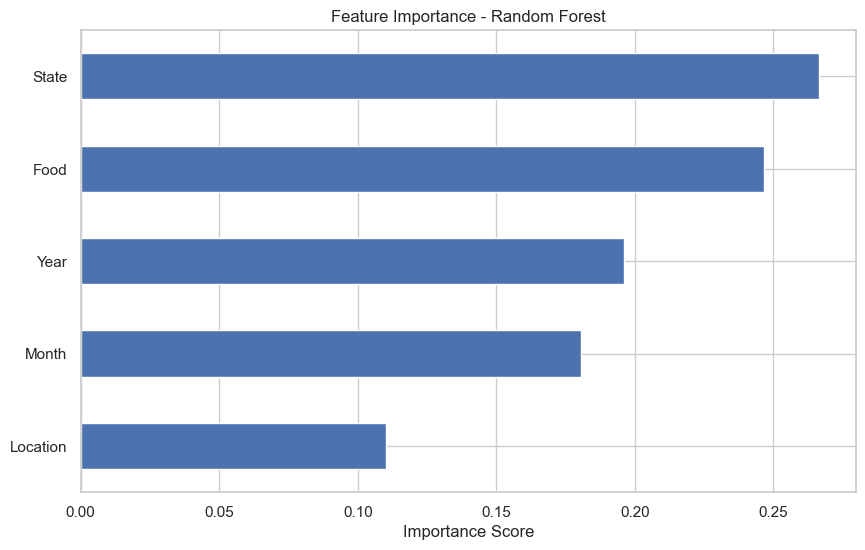

In [53]:
# Plot feature importance
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.show()


### Deep Learning

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [55]:
# Encode categorical features
df_dl = df_cleaned.copy()
features = ['Year', 'Month', 'State', 'Location', 'Food']
target = 'Hospitalized'

le_dict = {}
for col in features:
    if df_dl[col].dtype.name == 'category':
        le = LabelEncoder()
        df_dl[col] = le.fit_transform(df_dl[col])
        le_dict[col] = le

In [56]:
# Prepare input/output
X = df_dl[features]
y = df_dl[target]

In [57]:
# Normalize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [59]:
# Build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

C:\Users\asus\anaconda3\envs\Tanvi\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)


In [62]:
# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.7820781032078103

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4485
           1       0.52      0.01      0.02      1251

    accuracy                           0.78      5736
   macro avg       0.65      0.50      0.45      5736
weighted avg       0.73      0.78      0.69      5736



### Hyperparamater Tunning

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [64]:
# Instantiate model
rf = RandomForestClassifier(random_state=42)

In [65]:
# Randomized Search
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42)


In [66]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=2)

In [67]:
# Best model evaluation
best_model = rf_random.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nTuned Classification Report:\n", classification_report(y_test, y_pred_tuned))


Tuned Accuracy: 0.7878312412831241

Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88      4485
           1       0.62      0.07      0.12      1251

    accuracy                           0.79      5736
   macro avg       0.71      0.53      0.50      5736
weighted avg       0.76      0.79      0.71      5736



### Visualize Training Loss and Accuracy Curves

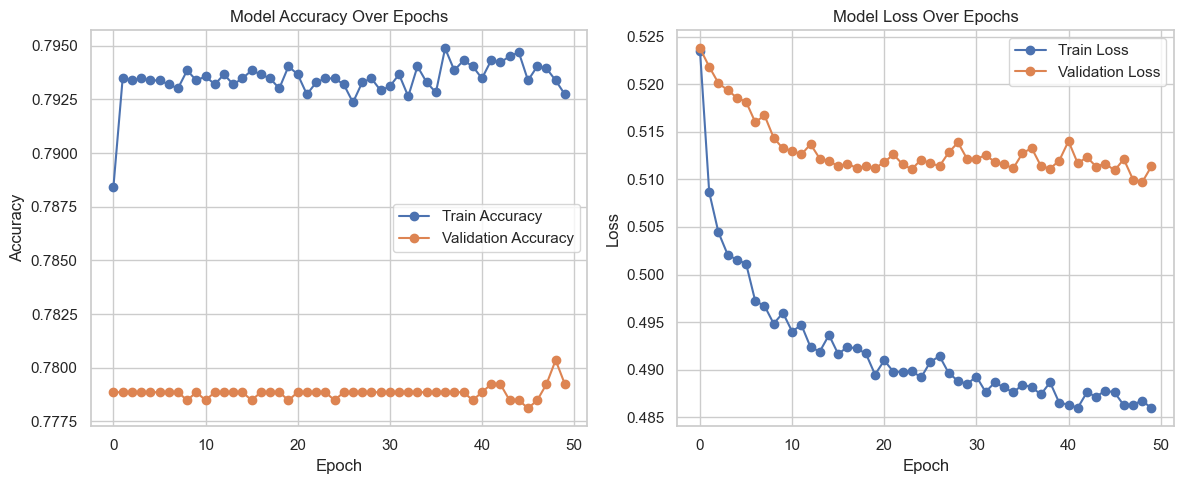

In [68]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Prediction 

In [69]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [70]:
# Convert to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

In [71]:
print("Test set Accuracy:", accuracy_score(y_test, y_pred))

Test set Accuracy: 0.7820781032078103


In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test set Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test set Confusion Matrix:
 [[4474   11]
 [1239   12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      4485
           1       0.52      0.01      0.02      1251

    accuracy                           0.78      5736
   macro avg       0.65      0.50      0.45      5736
weighted avg       0.73      0.78      0.69      5736



In [74]:
decoded_df = pd.DataFrame(X_test, columns=['Year', 'Month', 'State', 'Location', 'Food'])

# Add Actual and Predicted columns
decoded_df['Actual'] = y_test.values
decoded_df['Predicted'] = y_pred.flatten()

# Final DataFrame
final_df = decoded_df.copy()

# View top results
final_df.head(10)          # Actual = 1, Predicted = 0 means a false negative,
                           # Actual = 0, Predicted = 1 means a false positive.


,Year,Month,State,Location,Food,Actual,Predicted
0,1.054157,-0.991693,0.068351,0.124513,-0.039485,0,0
1,-0.109023,0.787075,-1.149002,-1.101668,0.795128,0,0
2,-0.302887,-1.288154,-0.572361,-2.102632,0.795128,0,0
3,-0.109023,0.490613,-0.380148,-0.951523,0.795128,1,0
4,-0.496750,-1.584616,-0.892718,0.124513,0.423481,0,0
5,-1.272204,-0.991693,0.068351,-2.102632,0.343842,0,0
6,1.829611,1.379997,1.541989,1.676008,0.788757,1,0
7,1.829611,-1.288154,-1.084931,-1.376933,0.795128,0,0
8,-1.078341,-1.288154,0.901277,0.124513,0.211111,1,0
9,0.084840,1.083536,-0.636433,0.124513,-1.199024,0,0


In [75]:
# View Only Incorrect Predictions
incorrect_preds = final_df[final_df['Actual'] != final_df['Predicted']]
incorrect_preds.head(10)

,Year,Month,State,Location,Food,Actual,Predicted
3,-0.109023,0.490613,-0.380148,-0.951523,0.795128,1,0
6,1.829611,1.379997,1.541989,1.676008,0.788757,1,0
8,-1.078341,-1.288154,0.901277,0.124513,0.211111,1,0
13,1.635748,0.787075,-1.149002,-1.577126,0.795128,1,0
17,1.054157,-0.102309,-0.123863,-0.701282,0.355522,1,0
23,-0.109023,-0.102309,-1.149002,0.124513,-2.075050,1,0
25,-1.078341,1.379997,-0.572361,0.750116,0.877952,1,0
26,-0.496750,1.083536,1.029419,0.124513,0.795128,1,0
28,1.441884,-1.584616,1.734202,0.124513,0.795128,1,0
30,1.635748,-1.288154,-0.572361,-2.102632,0.795128,1,0


### Confusion Matrix Visualization 

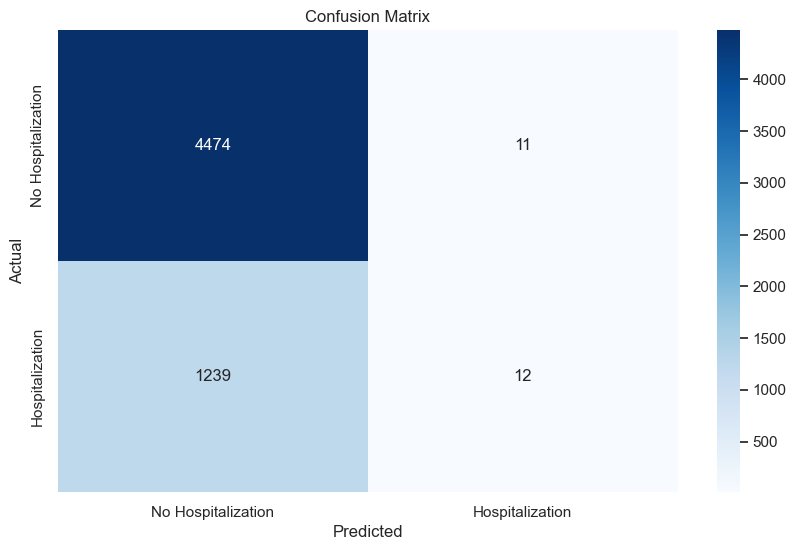

In [76]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Hospitalization', 'Hospitalization'],
            yticklabels=['No Hospitalization', 'Hospitalization'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
